In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import glob
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import matplotlib as mpl

dpi = 200
mpl.rcParams['figure.dpi'] = dpi
sns.set_context("notebook")

import pandas as pd
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *

### Load in data

In [4]:
savedir = "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/model/"

In [10]:
ds = xr.open_dataset(
        datadir("/model/Southern_Ocean_WMT_Budget.nc"))

ds["BF_Adv"] = ds["surface_ocean_flux_advective_negative_rhs"]
ds["BF_NonAdv"] = ds["boundary_fluxes"] - ds["BF_Adv"]


ds["boundary_fluxes_heat"] = ds["surface_ocean_flux_advective_negative_rhs_heat"] +\
                                 ds["surface_exchange_flux_heat"] +\
                                 ds["frazil_ice_heat"] + ds["bottom_flux_heat"]

ds["boundary_fluxes_salt"] = ds["surface_ocean_flux_advective_negative_rhs_salt"] +\
                                 ds["surface_exchange_flux_salt"]
ds["other_bf_terms"] = ds["boundary_fluxes"] - (ds["surface_ocean_flux_advective_negative_rhs_salt"] + ds["surface_exchange_flux_heat"])

ds["other_plot_terms"] = ds["mass_source"] + ds["other_bf_terms"]



### Extract water mass budget

The closed numerical $\lambda$-WMT budget is given in Drake et. al 2024's Equation 43. The budget is given by: 
$$-\partial_t \mathcal{M}_\geq + \mathcal{S}_\geq + \Psi_\geq + \mathcal{G}^{BF}_\geq + \mathcal{G}^{Mix}_\geq + \mathcal{G}^{Spurious}_\geq = 0$$

Here: 
- $ \mathcal{M}(\tilde \lambda, t)_\geq = \int_\Omega \rho dV $ is the set of all waters bounded by a material surface $\tilde \lambda$
-  $\partial_t \mathcal{M}_\geq$ the rate of change of the mass of that water that is bounded by $\tilde \lambda$
    - $\tilde \lambda$ can be a density, so that $\partial_t \mathcal{M}_\geq$ describes the actual mass of waters denser than $\tilde \lambda$
    - When $\tilde \lambda$ is a density surface, $\partial_t \mathcal{M}_\geq > 0$ implies the mass of waters denser than $\tilde \lambda$ is decreasing
- If the region $\omega$ contains open boundaries (i.e. the focus is on a particular ocean), then mass is not conserved. Mass can enter freely via ocean circulation. This movement of mass along the horizontal boundaries is given by $\Psi_\geq$.
- $\mathcal{G}^{BF}_\geq$ is the contribution of mass change from boundary fluxes including mixing processes at the surface, seafloor and sea-ice.
- $\mathcal{G}^{Mix}_\geq$ includes the effects of parameterized mixing
- $\mathcal{G}^{Spurious}_\geq$ includes the effects of spurios mixing, from a models advection scheme. Obtained as a residual. 


In [11]:
sigma = 37.00
toSv = 1/1035*1e-6
toTg = 1e-9 

mass_flux_units = "Tg/s"
mass_flux_units_conversion = toTg


In [24]:
experiments = ['forced', 'control']
nexpt = len(experiments)

budgets = ['mass_tendency', 
           'surface_exchange_flux_heat',
           'surface_ocean_flux_advective_negative_rhs_salt',
           'diffusion', 
           'spurious_numerical_mixing',
           'convergent_mass_transport', 
           'other_plot_terms', 
           ]

budgets_labels = [r"$\partial_{t} \mathcal{M}_{\geq}$", 
                  r"$\mathcal{G}^{SFC, \theta}_{\geq}$",
                  r"$\mathcal{G}^{SFC, FW}_{\geq}$",
                  r"$\mathcal{G}^{mix}_{\geq}$",
                  r"$\mathcal{G}^{Spu}_{\geq}$",
                  r"$\Psi_{\geq}$", 
                  r"$O.T$", 
                  ]
times = ("2050", "2100")

alphas = [1, 0.4, 0.4, 0.4, 0.4, 1, 0.4]
ncols = len(times)

expt_colors = dict(); expt_colors["control"] = "#2f74b3"; expt_colors["forced"] = "#cc415a"

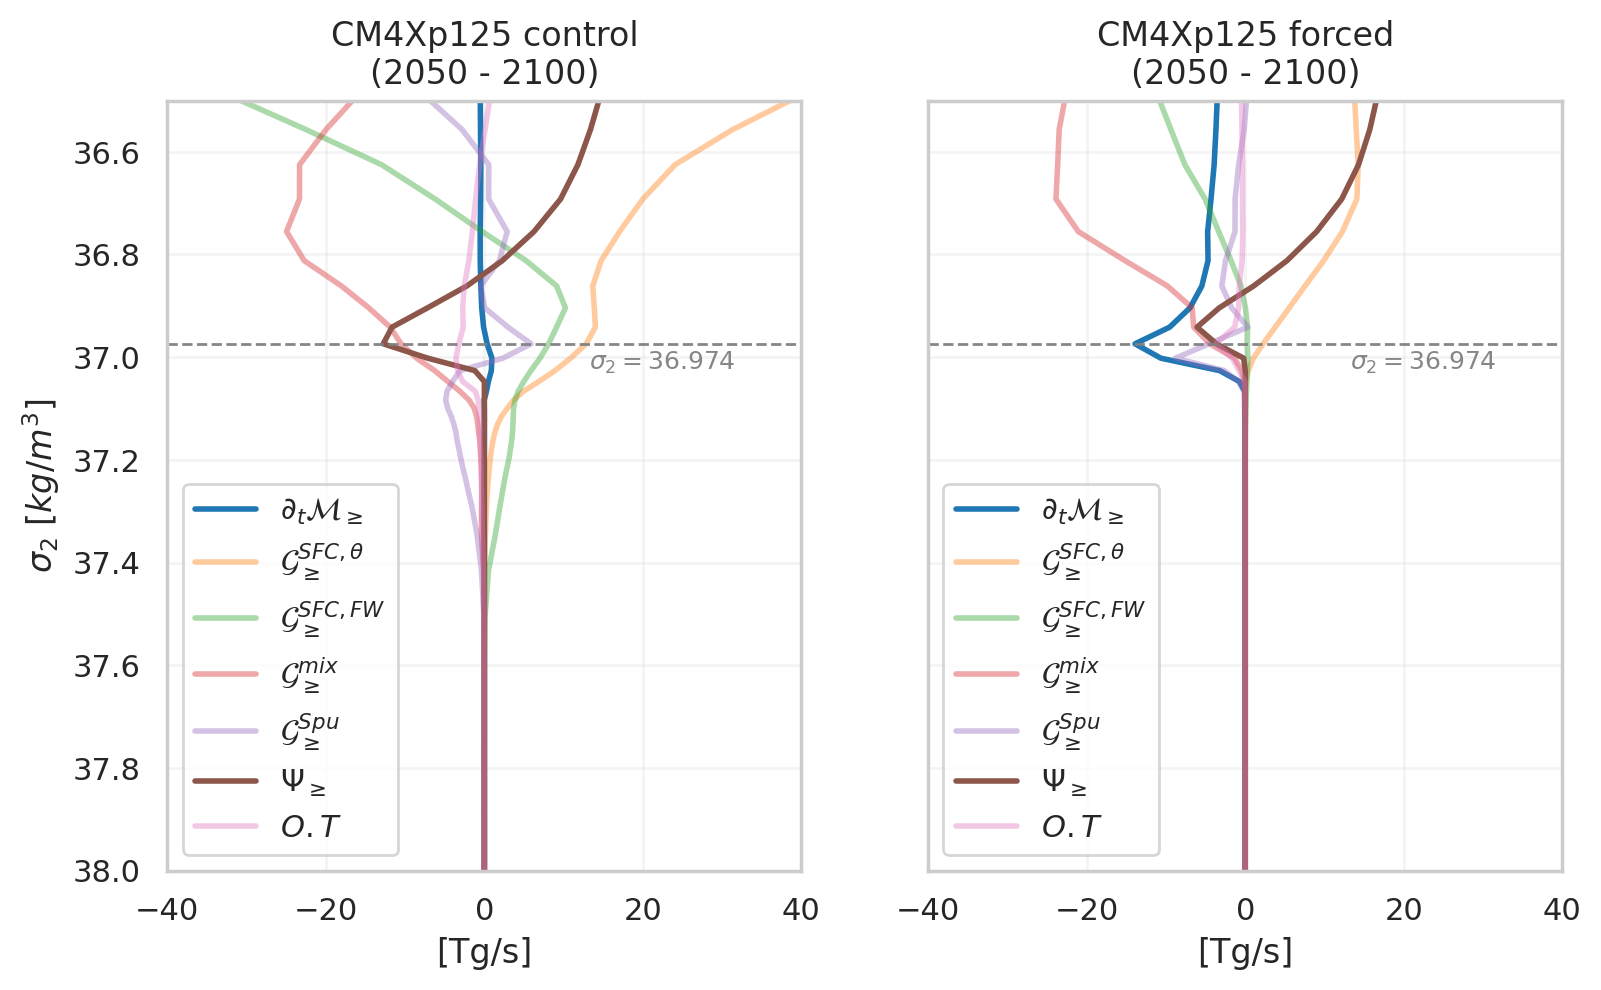

In [29]:
ds_mean = ds.sel(time = slice(times[0], times[1])).mean("time")
fig, ax = plt.subplots(1, 2, figsize = (9, 5),sharey = True, sharex = True)
for (i, exp) in enumerate(budgets):
    ax[1].set_title("CM4Xp125 forced\n(2050 - 2100)")
    ax[1].plot(mass_flux_units_conversion * ds_mean.sel(exp = "forced")[exp], 
               ds_mean.sigma2_l_target, 
               label = budgets_labels[i], lw = 2.0,alpha = alphas[i])
    ax[0].set_title("CM4Xp125 control\n(2050 - 2100)")
    ax[0].plot(mass_flux_units_conversion * ds_mean.sel(exp = "control")[exp], 
               ds_mean.sigma2_l_target,
               label = budgets_labels[i], lw = 2.0,alpha = alphas[i])

for a in ax:
    a.axhline([36.974], c = "grey", alpha = 0.95, lw = 1, linestyle = "--")
    a.annotate(r"$\sigma_2 = 36.974$", xy=(13.2, 37.01), fontsize = 9,
                      xytext=(0, 0), textcoords="offset points",
                      va="center", c = "grey", alpha = 0.95)


[a.legend() for a in ax]
ax[0].set_ylabel(r"$\sigma_2$" + " " + r"$[kg/m^3]$")
[a.set_xlabel("[Tg/s]") for a in ax]
ax[1].set_ylim(36.5, 38.)
ax[1].set_xlim(-40, 40)
ax[1].invert_yaxis()
[a.grid(alpha = 0.2) for a in  ax]
fig.savefig(plotsdir("supp_paper_figures/Profile_Budget.png"), dpi = 200, bbox_inches = "tight")

In [79]:
def stairs(wmt, var, ax, **kwargs):
    da = mass_flux_units_conversion * wmt[var]
    coord = wmt[[c for c in wmt.coords if "l_target" in c][0]]
    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    l = ax.stairs(da, coord_bounds, **kwargs, orientation="horizontal")
    return l

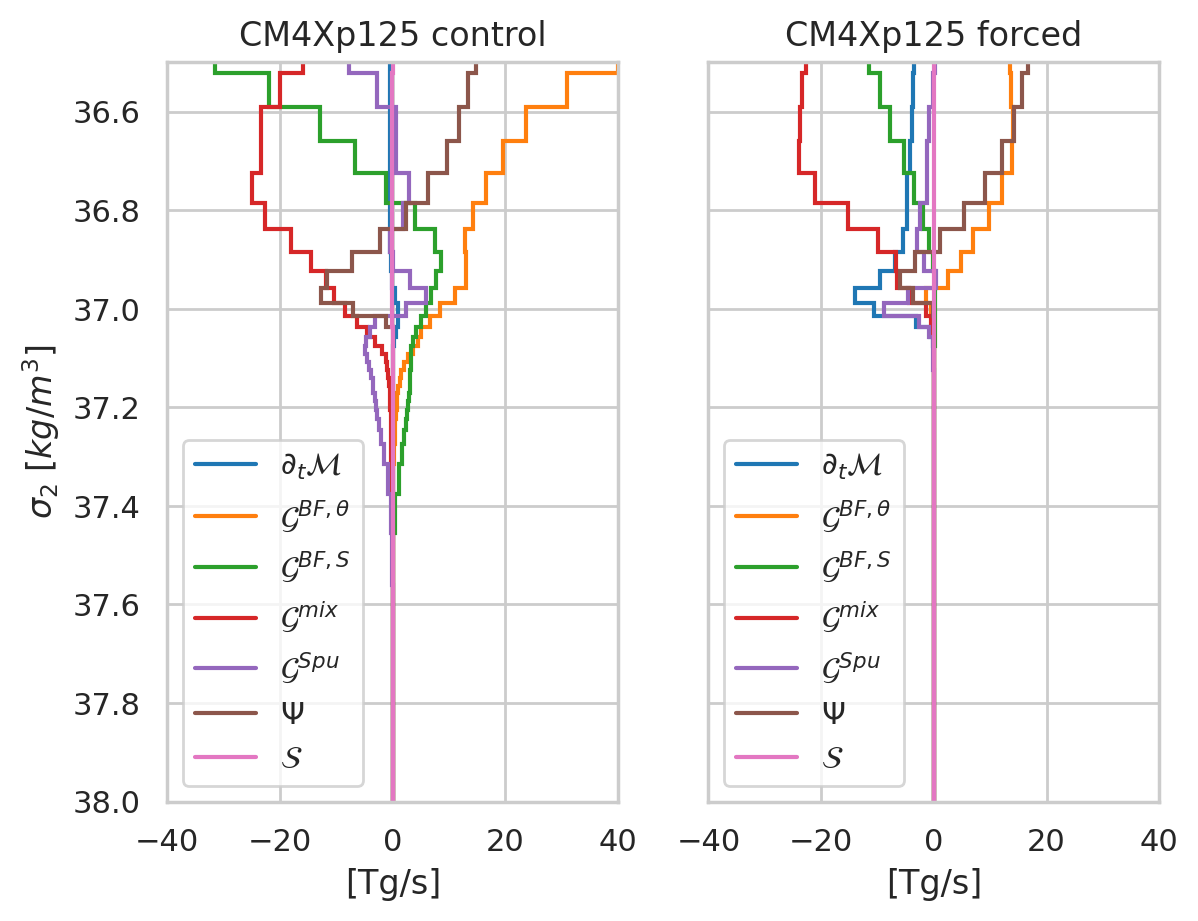

In [87]:
ds_mean = ds.sel(time = slice(times[0], times[1])).mean("time")
fig, ax = plt.subplots(1, 2, sharey = True, sharex = True)
for (i, var) in enumerate(budgets):
    ax[1].set_title("CM4Xp125 forced")
    stairs(ds_mean.sel(exp = "forced"), var, ax[1], label = budgets_labels[i], lw = 1.5)
    
    ax[0].set_title("CM4Xp125 control")
    stairs(ds_mean.sel(exp = "control"), var, ax[0], label = budgets_labels[i], lw = 1.5)
[a.legend() for a in ax]
ax[0].set_ylabel(r"$\sigma_2$" + " " + r"$[kg/m^3]$")
[a.set_xlabel("[Tg/s]") for a in ax]
ax[1].set_ylim(36.5, 38.)
ax[1].set_xlim(-40, 40)
ax[1].invert_yaxis()